In this notebook, we generate finite element data for training neural operators.

### General Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from mesher import Mesh2D
from conditions import BoundaryCondition
from materials import LinearElastic
from solver import NFEA

In [3]:
def get_periodic_pairs(mesh: 'Mesh2D', tol: float = 1e-8):
    """
    Generate periodic node pairs for a 2D mesh based on its geometry and node groups.
    """

    coords = mesh.coordinates  # shape (nnod, 2)

    # Get boundary nodes
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

    left_nodes   = mesh.find_nodes(x_min, axis=1, tol=tol)
    right_nodes  = mesh.find_nodes(x_max, axis=1, tol=tol)
    bottom_nodes = mesh.find_nodes(y_min, axis=2, tol=tol)
    top_nodes    = mesh.find_nodes(y_max, axis=2, tol=tol)

    # LEFT & RIGHT pairs (same Y-value)
    y_to_right = {round(coords[nid-1, 1], 8): nid for nid in right_nodes}

    left_right_pairs = []
    for nid_l in left_nodes:
        y_key = round(coords[nid_l-1, 1], 8)
        if y_key in y_to_right:
            left_right_pairs.append((nid_l, y_to_right[y_key]))

    # BOTTOM & TOP pairs (same X-value)
    x_to_top = {round(coords[nid-1, 0], 8): nid for nid in top_nodes}

    bottom_top_pairs = []
    for nid_b in bottom_nodes:
        x_key = round(coords[nid_b-1, 0], 8)
        if x_key in x_to_top:
            bottom_top_pairs.append((nid_b, x_to_top[x_key]))

    # Sort by coordinates
    left_right_pairs.sort(key=lambda p: coords[p[0]-1, 1])   # sort by Y
    bottom_top_pairs.sort(key=lambda p: coords[p[0]-1, 0])   # sort by X

    return left_right_pairs, bottom_top_pairs

In [4]:
from conditions import PeriodicBoundaryCondition

soft = LinearElastic(emod =  20*1e3, nu = 0.25)
hard = LinearElastic(emod = 200*1e3, nu = 0.25)

delta_x = 0.10      # RVE size in X direction in (mm)
delta_y = 0.10      # RVE size in Y direction in (mm)

meshes_folder = Path("./meshes")
strain_folder = Path("./strain_histories")

mesh_files  = sorted(meshes_folder.glob("*.med"))               # mesh 1, mesh 2, ...
strain_files = sorted(strain_folder.glob("strain_*.csv"))       # strain_1.csv, strain_2.csv, ...

# batch to solve
b_ini = 1       # inclusive
b_end = 1       # inclusive

for idx in range(b_ini, b_end + 1):
    if idx < b_ini:
        continue
    if idx > b_end:
        break
    
    mesh_file = mesh_files[idx-1]
    strain_file = strain_files[idx-1]

    print(f"Processing {idx}/{b_end} → {mesh_file.name}")
    
    # Read mesh
    mesh = Mesh2D.from_salome_med(filepath=mesh_file, verbose=False)
    left_right_pairs, bottom_top_pairs = get_periodic_pairs(mesh)

    # Define boundary conditions
    bcs = {
        'fixed_n': [BoundaryCondition(dof=1, value=0.0),
                    BoundaryCondition(dof=2, value=0.0)],  
        }
    
    # Define periodic boundary conditions
    strain_data = np.genfromtxt(
            strain_file,
            delimiter=',',
            names=True,
            dtype=float,
            skip_header=0
        )

    exx = strain_data['exx']
    eyy = strain_data['eyy']
    gxy = strain_data['gxy']
    n_steps = len(exx)

    pbc = PeriodicBoundaryCondition(
        exx=exx[0],
        eyy=eyy[0],
        gxy=gxy[0],
        left_right_pairs=left_right_pairs,
        bottom_top_pairs=bottom_top_pairs,
        delta_x=delta_x,
        delta_y=delta_y
        )

    mpcs = pbc.get_constraints()

    # Define material field mapping
    matfield = {'soft_s': soft, 
                'hard_s': hard}

    # Instance FEA solver
    fem_solver = NFEA(mesh = mesh, 
                        bcs = bcs,
                        matfld = matfield,
                        mpcs=mpcs,
                        verbose = False
                        )
    
    # Solve for each step
    for step in range(1, n_steps):
        print(f"  Step {step}/{n_steps-1} → exx={exx[step]:.4f}, eyy={eyy[step]:.4f}, gxy={gxy[step]:.4f}")
        pbc.update_strains(new_exx=exx[step], new_eyy=eyy[step], new_gxy=gxy[step])
        fem_solver.update_mpc_b0s()
        fem_solver.run_complete(nsteps=1)


Processing 1/1 → RVE_8x8_f0.40_case01.med
  Step 1/100 → exx=-0.0001, eyy=0.0003, gxy=0.0003
  Step 2/100 → exx=-0.0001, eyy=0.0007, gxy=0.0005
  Step 3/100 → exx=-0.0002, eyy=0.0010, gxy=0.0006
  Step 4/100 → exx=-0.0003, eyy=0.0014, gxy=0.0008
  Step 5/100 → exx=-0.0004, eyy=0.0017, gxy=0.0008
  Step 6/100 → exx=-0.0005, eyy=0.0020, gxy=0.0009
  Step 7/100 → exx=-0.0006, eyy=0.0023, gxy=0.0008
  Step 8/100 → exx=-0.0008, eyy=0.0026, gxy=0.0008
  Step 9/100 → exx=-0.0009, eyy=0.0029, gxy=0.0007
  Step 10/100 → exx=-0.0010, eyy=0.0032, gxy=0.0005
  Step 11/100 → exx=-0.0011, eyy=0.0034, gxy=0.0004
  Step 12/100 → exx=-0.0012, eyy=0.0036, gxy=0.0002
  Step 13/100 → exx=-0.0013, eyy=0.0038, gxy=-0.0001
  Step 14/100 → exx=-0.0014, eyy=0.0040, gxy=-0.0003
  Step 15/100 → exx=-0.0015, eyy=0.0041, gxy=-0.0006
  Step 16/100 → exx=-0.0016, eyy=0.0042, gxy=-0.0009
  Step 17/100 → exx=-0.0017, eyy=0.0043, gxy=-0.0012
  Step 18/100 → exx=-0.0018, eyy=0.0044, gxy=-0.0015
  Step 19/100 → exx=-0.00

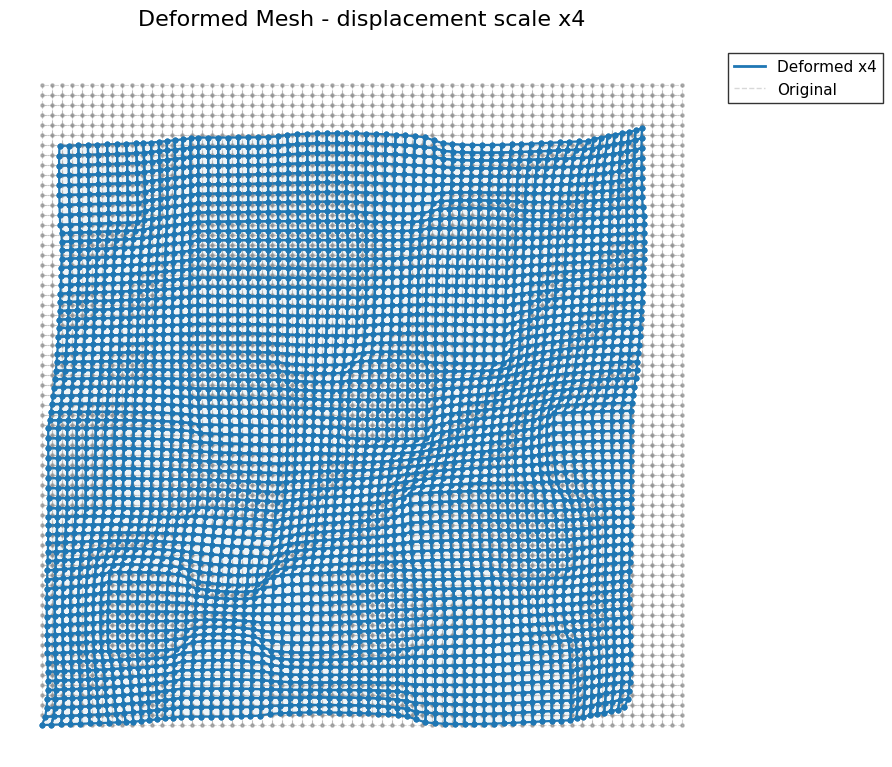

In [11]:
fem_solver.plot_deformed_mesh(scale=4)